# Striplogs from cuttings spreadsheets

We want to extract `striplogs` from cuttings descriptions, and save them as LAS files. I'd like to save both the original verbatim descriptions, as transcribed from PDF files, as well as the synthesized `rock` parameters — which will be of highly variable quality.

In [1]:
from striplog import Striplog, Legend, Lexicon
legend = Legend.default()
lexicon = Lexicon.default()

In [3]:
import xlrd
xls = "data/cuttings/Nova_Scotia_cuttings_extract.xlsx"
book = xlrd.open_workbook(xls)
name = "P-129"
sh = book.sheet_by_name(name)

In [24]:
sh.book.sheet_names()

['P-129', 'P-130', 'P-131']

The data in this spreadsheet are spread over one sheet per well; the sheets look like this:

<img src="cuttings_" />

The data I'm interested in are in green.

First we'll make a quick helper function.

In [25]:
def not_decreasing(L):
    return all(x<=y for x, y in zip(L[:-1], L[1:]))

Now we can set up a loop to traverse the sheets in the XLS file, collecting the data we need and doing some basic sanity checking on it. If it passes the sanity check, we create a striplog and add it to the dictionary.

In [53]:
from welly import Well, Header

In [66]:
import numpy as np

striplogs = {}

for s in book.sheet_names():
    name = s
    sh = book.sheet_by_name(name)
    
    units = sh.cell_value(rowx=2, colx=1)
    abbr  = sh.cell_value(rowx=2, colx=3)
    tops  = np.array([float(c.value) for c in sh.col_slice(0, 4)])
    bases = np.array([float(c.value) for c in sh.col_slice(1, 4)])
    descr = [c.value.encode('utf-8') for c in sh.col_slice(3, 4)]
    
    if not (not_decreasing(tops) and not_decreasing(bases)):
        print ("* Decreasing values:", name)
        continue
    
    if units.lower() in ['ft', 'feet']:
        tops *= 0.3048
        bases *= 0.3048
        
    # Make the striplog, then make a well, and add the striplog to it.
    try:
        striplog = Striplog._from_array(list(zip(tops, bases, descr)), lexicon, abbreviations=lexicon.abbreviations)
    except (Exception):
        print ("* Failed to convert", name)
        continue
    
    striplogs[name] = striplog
    
    print ("- Done", name)

/Users/Evan/anaconda/envs/welly/lib/python3.5/site-packages/striplog/striplog.py:597: UserWarning: from_array() is deprecated.
  warnings.warn(w)
/Users/Evan/anaconda/envs/welly/lib/python3.5/site-packages/striplog/striplog.py:597: UserWarning: from_array() is deprecated.
  warnings.warn(w)


- Done P-129
- Done P-130
- Done P-131


/Users/Evan/anaconda/envs/welly/lib/python3.5/site-packages/striplog/striplog.py:597: UserWarning: from_array() is deprecated.
  warnings.warn(w)


Call the plot method without any keyword arguments to see the striplog with random colors

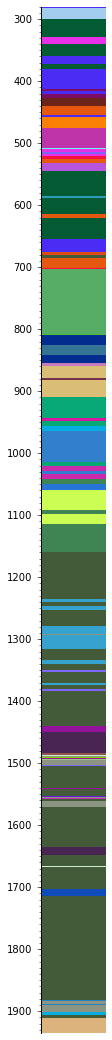

In [67]:
striplogs['P-129'].plot()

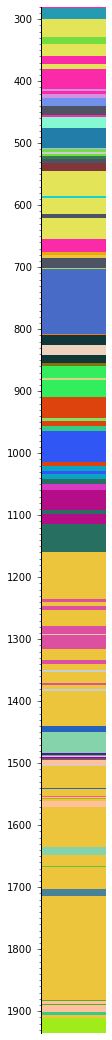

In [71]:
striplogs['P-129'].plot()

Look at the first (zeroth) interval of a striplog

In [79]:
striplogs['P-130'][0]

Interval({'top': Position({'units': 'm', 'middle': 20.0}), 'base': Position({'units': 'm', 'middle': 30.0}), 'description': "b'Sandstone: greenish to yellowish grey, fine lower to moderate lower, sub angular, moderately well sorted, free calcite crystals, slightly calcareous cement, thin grey shale interbeds, 6 to 9 % porosity, Sneider 2'", 'components': [Component({'amount': 'interbeds', 'colour': 'greenish', 'grainsize': 'fine', 'lithology': 'sandstone'})]})

With this particular lexicon, we have not extracted a lot of `rock`s, however:

## Save data to LAS files

When we write out the data, we can choose to write out the entire descriptions (if any), or just the summaries of the primary rocks (i.e. the first in the list of components).

In [8]:
from striplog import templates
import time

In [9]:
def form_las(well, striplog):
    time_now = time.strftime("%Y/%m/%d %H:%M", time.gmtime())
    result = templates.las.format(
                  prog='striplog.py',
                  date=time_now,
                  start=striplog.start,
                  stop=striplog.stop,
                  step=-999.25,
                  null=-999.25,
                  well=well,
                  uwi='',
                  lic=well,
                  apd=-999.25,
                  eref=-999.25,
                  #section=striplog.to_las3(use_descriptions=True), # to capture full text
                  section=striplog.to_las3(),                       # to get primary rocks only
                  curve='')
    return result.strip() + '\n'

In [10]:
import re, os
def write_las(data, path, suffix=None, overwrite=False):
    if not suffix:
        suffix = time.strftime("%Y%m%d-%H%M%S", time.gmtime())
    
    w = re.findall(r'\nWELL \.(.+?)\:WELL', data)[0].strip()
    file_name = re.sub(r' ', r'_', w) + '_{0}.las'.format(suffix)
    
    full_path = os.path.join(path, file_name)
    
    if (not os.path.isfile(full_path)) or overwrite:
        with open(full_path, 'w') as f:
            f.write(data)
    else:
        print w, "... file exists, not overwritten"

In [11]:
path = "../data/LAS"
for name, well in wells.items():
    data = form_las(name, well.striplog.cuttings)
    write_las(data, path, suffix='striplog_from_cuttings', overwrite=True)

In [12]:
ls -l ../data/LAS/*_from_cuttings.las

-rw-r--r--@ 1 matt  staff   4602 27 Mar 09:53 ../data/LAS/M-G-24_striplog_from_cuttings.las
-rw-r--r--@ 1 matt  staff  13018 27 Mar 09:53 ../data/LAS/M-Malagawatch-2_striplog_from_cuttings.las
-rw-r--r--@ 1 matt  staff   3142 27 Mar 09:53 ../data/LAS/M-Malagawatch-2b_striplog_from_cuttings.las
-rw-r--r--@ 1 matt  staff  11956 27 Mar 09:53 ../data/LAS/M-Morton1_striplog_from_cuttings.las
-rw-r--r--@ 1 matt  staff  14515 27 Mar 09:53 ../data/LAS/M-Morton2_striplog_from_cuttings.las
-rw-r--r--@ 1 matt  staff  12317 27 Mar 09:53 ../data/LAS/M-NorthSyd-F-24_striplog_from_cuttings.las
-rw-r--r--@ 1 matt  staff   4174 27 Mar 09:53 ../data/LAS/M-PE-83-1_striplog_from_cuttings.las
-rw-r--r--@ 1 matt  staff   4645 27 Mar 09:53 ../data/LAS/M-PE84-1_striplog_from_cuttings.las
-rw-r--r--@ 1 matt  staff   6418 27 Mar 09:53 ../data/LAS/M-SYD-82-1_striplog_from_cuttings.las
-rw-r--r--@ 1 matt  staff  33619 27 Mar 09:53 ../data/LAS/M-StPaul-P-91_striplog_from_cuttings.las
-rw-r--r--@ 1 matt  staff   65

## Search the 'database'

This `try`/`except` is not very good practice, especially with a `pass` in the exception, but it means we can cope with some errors in the `find` call, resulting from empty descriptions (I think). The idea was to illustrate a point:

In [13]:
hits, cums = [], []
for well, data in wells.items():
    try:
        oil = data.striplog.cuttings.find('oil')  # Will be None if nothing
        if oil:
            hits.append(well)
            cums.append(oil.cum)
    except:
        pass

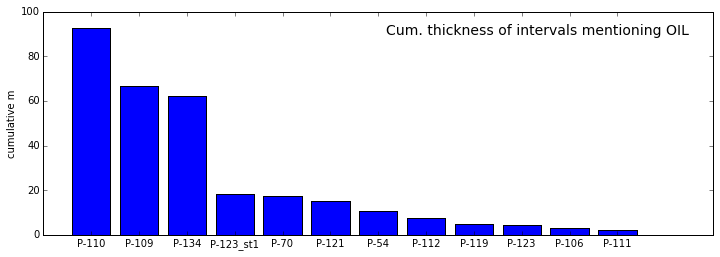

In [14]:
import matplotlib.pyplot as plt

# Make a var for the x-axis (just the way plt.bar() works.)
x = np.arange(len(hits)) + 1

# This trick sorts a zipped list, then unpacks it into two variables again:
hits, cums = zip(*sorted(zip(hits, cums), key=lambda x: x[1], reverse=True))

# Make the plot.
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.bar(x, cums, align='center')
ax.set(xticks=x, xticklabels=hits)
plt.ylabel('cumulative m')
plt.text(13.5, 90, 'Cum. thickness of intervals mentioning OIL', fontsize=14, ha='right')
plt.show()

## Create a legend and map cuttings descriptions to legend